In [1]:
import sys 

In [ ]:
cd '/srv/share3/hagrawal9/project/habitat/habitat-api/'

In [ ]:
import gzip
import json
import os
import sys
from typing import Any, Dict, List, Optional, Type

import attr
import cv2
import git
import magnum as mn
import numpy as np

# %matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image


import habitat
import habitat_sim
from habitat.config import Config
from habitat.core.registry import registry
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps, fog_of_war
from habitat.utils.visualizations.utils import observations_to_image

from rearrangement.utils.planner import (
    compute_traversable_map,
    find_all_pair_shortest_path
)

In [ ]:
sys.path.append('/srv/share3/hagrawal9/project/habitat/habitat-api/rearrangement/')

In [ ]:
from habitat.datasets.rearrangement.rearrangement_dataset import RearrangementDatasetV0
from habitat.tasks.rearrangement.rearrangement_task import RearrangementEpisode

In [6]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
# %cd $dir_path
data_path = os.path.join(dir_path, "data")
output_directory = "data/tutorials/output/"  # @param {type:"string"}
output_path = os.path.join(dir_path, output_directory)

In [7]:
config = habitat.get_config("configs/tasks/rearrangement_gibson.yaml")

In [8]:
config.defrost()
config.SIMULATOR.INITIAL_LOOK_DOWN_ANGLE = 0
config.TASK.MEASUREMENTS = ['OBJECT_TO_GOAL_DISTANCE', 'AGENT_TO_OBJECT_DISTANCE', 'TOP_DOWN_MAP']
config.freeze()

In [9]:
def make_video_cv2(
    observations, cross_hair=None, prefix="", open_vid=True, fps=60
):
    sensor_keys = list(observations[0])
    videodims = observations[0][sensor_keys[0]].shape
    videodims = (videodims[1], videodims[0])  # flip to w,h order
    print(videodims)
    video_file = output_path + prefix + ".mp4"
    print("Encoding the video: %s " % video_file)
    writer = vut.get_fast_video_writer(video_file, fps=fps)
    for ob in observations:
        # If in RGB/RGBA format, remove the alpha channel
        rgb_im_1st_person = cv2.cvtColor(ob["rgb"], cv2.COLOR_RGBA2RGB)
        if cross_hair is not None:
            rgb_im_1st_person[
                cross_hair[0] - 2 : cross_hair[0] + 2,
                cross_hair[1] - 2 : cross_hair[1] + 2,
            ] = [255, 0, 0]

        if rgb_im_1st_person.shape[:2] != videodims:
            rgb_im_1st_person = cv2.resize(
                rgb_im_1st_person, videodims, interpolation=cv2.INTER_AREA
            )
        # write the 1st person observation to video
        writer.append_data(rgb_im_1st_person)
    writer.close()

    if open_vid:
        print("Displaying video")
        vut.display_video(video_file)


In [10]:
def print_info(obs, metrics):
    print(
        "Gripped Object: {}, Distance To Object: {}, Distance To Goal: {}".format(
            obs["gripped_object_id"],
            metrics["agent_to_object_distance"],
            metrics["object_to_goal_distance"],
        )
    )

In [11]:
if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument(
        "--no-make-video", dest="make_video", action="store_false"
    )
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    make_video = args.make_video
else:
    show_video = False
    make_video = False
    display = False

In [12]:
try:
    env.close()
except:
    pass
env = habitat.Env(config)
fog_of_war_mask = None

2020-10-09 01:27:47,340 Initializing dataset RearrangementDataset-v0
2020-10-09 01:27:47,486 initializing sim RearrangementSim-v0
I1009 01:27:52.300378 36852 simulator.py:168] Loaded navmesh data/scene_datasets/gibson_train_val/Barboursville.navmesh
I1009 01:27:52.301577 36852 simulator.py:180] Recomputing navmesh for agent's height 0.88 and radius 0.18.
2020-10-09 01:27:52,393 Initializing task RearrangementTask-v0


In [19]:
def get_top_down_map(env, fog_of_war_mask=None, should_draw_fow=True, should_draw_agent=False, should_draw_object=False):
    
    env._sim.recompute_navmesh(env._sim.pathfinder, env._sim.navmesh_settings, False)

    top_down_map = maps.get_topdown_map(
        env._sim.pathfinder,
        env._sim.get_agent(0).state.position[1],
        1024
    )

    agent_position = env._sim.get_agent_state().position
    a_y, a_x = maps.to_grid(
        agent_position[2],
        agent_position[0],
        top_down_map.shape[0:2],
        sim=env._sim,
    )

    episode = env.current_episode
    object_positions = [obj.position for obj in episode.objects]
    goal_positions = [obj.position for obj in episode.goals]

    grid_object_positions = []
    grid_goal_positions = []

    for i, obj_pos in enumerate(object_positions):
        tdm_pos = maps.to_grid(
            obj_pos[2],
            obj_pos[0],
            top_down_map.shape[0:2],
            sim=env._sim,
        )
        grid_object_positions.append(tdm_pos)

    # draw the objectgoal positions.
    for i, goal_pos in enumerate(goal_positions):
        tdm_pos = maps.to_grid(
            goal_pos[2],
            goal_pos[0],
            top_down_map.shape[0:2],
            sim=env._sim,
        )

        grid_goal_positions.append(tdm_pos)
    
    agent_rotation = metrics["top_down_map"]["agent_angle"]
    # print(agent_rotation)
    
    if should_draw_fow:
        if fog_of_war_mask is None:
            fog_of_war_mask = np.zeros_like(top_down_map)
        
        fog_of_war_mask = fog_of_war.reveal_fog_of_war(
            np.ones(top_down_map.shape),
            fog_of_war_mask,
            np.array([a_y, a_x]),
            agent_rotation,
            fov = 90,
            max_line_len = 500
        )
    top_down_map = maps.colorize_topdown_map(top_down_map)
    
    if should_draw_agent:
        top_down_map = maps.draw_agent(
            image=top_down_map,
            agent_center_coord=[a_y, a_x],
            agent_rotation=agent_rotation,
            agent_radius_px=min(top_down_map.shape[0:2]) / 32,
        )
    
    if should_draw_object:
        top_down_map = maps.draw_object_info(top_down_map, grid_object_positions, grid_goal_positions)
    
    return top_down_map, fog_of_war_mask

In [60]:
obs = env.reset()
metrics = env.get_metrics()

rotating agent!


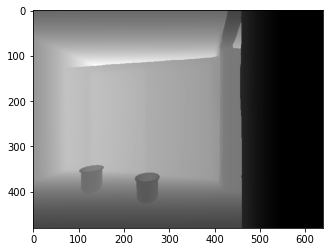

In [61]:
# agent0 = env._sim.set_agent_state?
for i in range(19):
    obs = env.step(2)

# for i in range(6):
#     obs = env.step(1)

# for i in range(5):
#     obs = env.step(2)

# for i in range(5):
#     obs = env.step(1)
    
# for i in range(10):
#     obs = env.step(2)
    
metrics = env.get_metrics()

plt.imshow(obs['depth'].reshape((480, 640)), cmap="gray")
plt.show()

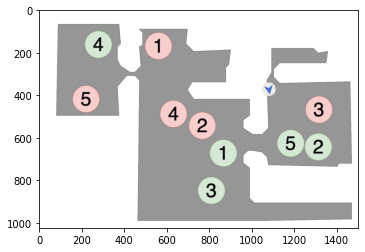

In [62]:
top_down_map, fog_of_war_mask = get_top_down_map(
    env, fog_of_war_mask, should_draw_fow=True, 
    should_draw_agent=True, should_draw_object=True
)

plt.imshow(top_down_map)
plt.show()

In [63]:
import torch 
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from torch_scatter import scatter_add

from projector.core import _transform3D
from projector.point_cloud import PointCloud




In [64]:
house_dim_min, house_dim_max = env._sim.pathfinder.get_bounds()

center = (house_dim_max + house_dim_min) / 2
sizes = house_dim_max - house_dim_min
sizes +=2 # pad scene bboxes

world_dim = sizes.copy(); world_dim[1] = 0.
central_pos = center.copy(); central_pos[1] = 0.

map_world_shift = central_pos - (world_dim / 2)
top_down_map_dims = [
    int(np.round(world_dim[0] / 0.02)),
    0,
    int(np.round(world_dim[2] / 0.02)),
]

In [65]:
top_down_map_dims, map_world_shift

([602, 0, 442], array([-6.3978987,  0.       , -2.650702 ], dtype=float32))

In [66]:
vfov = 67.5 * np.pi / 180
world_shift = torch.FloatTensor([0,0,0])
projector = PointCloud(vfov,
   1,
   480,
   640,
   world_shift,
   0.5,
   device=torch.device("cpu"),
)


sensor_state = env._sim.get_agent(0).state
sensor_pos, sensor_ori = (
    sensor_state.position,
    sensor_state.rotation
)

# 5.3 compute the 4x4 transformation matrix (camera -> world)
sensor_ori = np.asarray(
    [sensor_ori.x, sensor_ori.y, sensor_ori.z, sensor_ori.w],
    dtype=np.float32
)

rotation = R.from_quat(sensor_ori)
elevation, heading, _  = rotation.as_rotvec()
print(heading, elevation)
xyzhe = np.asarray(
    [[
        sensor_pos[0],
        sensor_pos[1],
        sensor_pos[2],
        heading,
        elevation + np.pi
    ]],
    dtype=np.float32
)
xyzhe = torch.FloatTensor(xyzhe)
T = _transform3D(xyzhe)

-2.9670599367197257 -0.0


In [67]:
# -- depth for projection
depth = obs['depth']
depth = depth[:,:,0]

In [51]:
depth[:] = 0.001

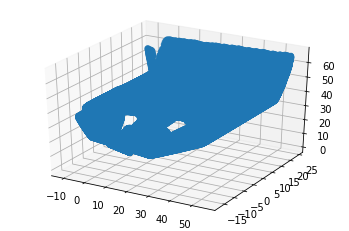

In [83]:
depth = depth.astype(np.float32)
depth *= 10.0
depth_var = torch.FloatTensor(depth).unsqueeze(0).unsqueeze(0)

pc, mask_outliers = projector.forward(depth_var, T)

pc = pc[~mask_outliers]

pc = pc.numpy()

# pc = pc[0:-1:50, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = pc.reshape(-1, 3)[:,0]
y = pc.reshape(-1, 3)[:,1]
z = pc.reshape(-1, 3)[:,2]

ax.scatter(x, y, z)

plt.show()

In [84]:
pc.shape

(264506, 3)

In [85]:
camera_z = T[:,2,3]
above_threshold_z_indices = pc[:, :, :, 1] > (0)
# mask1 = mask & ~above_threshold_z_indices

IndexError: too many indices for array

In [93]:
dproj = np.copy(pc)[:, 1]
dxyz = np.copy(pc)

dmask = np.zeros_like(dproj)

In [95]:
tdmap = np.copy(top_down_map)
for i in range(dxyz.shape[0]):
    # if dmask[i,j] == 1:
    val = dxyz[i]
    # val = val - map_world_shift.cpu().numpy()
    pos = maps.to_grid(-val[2], val[0], top_down_map.shape[0:2] ,env._sim, env._sim.pathfinder)
    # pos = (pos[0]*2, pos[1]*2)
    if pos[0] < tdmap.shape[0] and pos[1] < tdmap.shape[1]:
        tdmap[pos[0], pos[1], :] = [0, 0, 0]


IndexError: index -4325 is out of bounds for axis 0 with size 1024

In [94]:
dmask[dproj >= -0.01648646] = 1
dxyz[350, 400] = (0, 0, 0)
plt.imshow(dxyz[:, :, 2])

IndexError: index 400 is out of bounds for axis 1 with size 3

In [89]:
print(dxyz[380, 120], dxyz[400, 250])
for i in [2, 5]:
    # print(env._task.objid_to_sim_object_mapping)
    objid = env._task.objid_to_sim_object_mapping[i-1]
    print(objid)
    print(env._sim.get_translation(objid))
    # env._sim.get_translation(1), env._sim.get_translation(2), env._sim.get_translation(3), env._sim.get_translation(4), env._sim.get_translation(5)


[ 4.304217 -1.080654  3.604349] [ 2.816411  -0.997452   3.2781122]
3
Vector(3.36994, 0.187652, 2.64396)
0
Vector(2.49928, 0.190463, 2.53236)


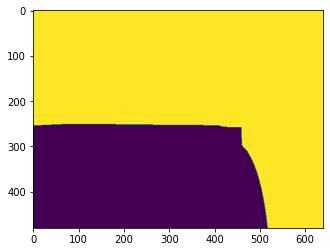

In [90]:
plt.imshow(dmask)

In [91]:
tdmap = np.copy(top_down_map)
for i in range(dxyz.shape[0]):
    for j in range(dxyz.shape[1]):
        # if dmask[i,j] == 1:
        val = dxyz[i, j]
        # val = val - map_world_shift.cpu().numpy()
        pos = maps.to_grid(-val[2], val[0], top_down_map.shape[0:2] ,env._sim, env._sim.pathfinder)
        # pos = (pos[0]*2, pos[1]*2)
        if pos[0] < tdmap.shape[0] and pos[1] < tdmap.shape[1]:
            tdmap[pos[0], pos[1], :] = [0, 0, 0]


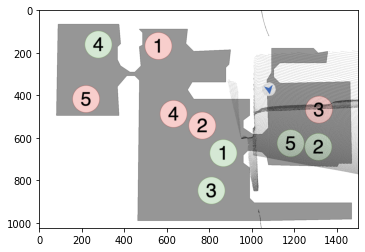

In [92]:
plt.imshow(tdmap)

In [111]:
camera_z = T[:,2,3]
print(camera_z)

tensor([0.8368], device='cuda:0')


In [357]:
# 5.6 map point-cloud to discrete top-down grid coordinates
tmp_pc = pc.clone() # (B=1, 480, 640, 3)
tmp_mask = np.copy(dmask)

tmp_pc = tmp_pc.view(-1, 3) # (1x480x640, 3)
tmp_mask = tmp_mask.reshape(-1)
tmp_pc -= map_world_shift # origin of world at upper-left of top-down map

# (x,z) grid-coordinates of points when projected to ground-plane
vertex_to_map_x = (tmp_pc[:, 0] / 0.02).round() # (1x480x640, float32)
vertex_to_map_z = (tmp_pc[:, 2] / 0.02).round() # (1x480x640, float32)

In [237]:
outside_map_indices = \
    (vertex_to_map_x >= top_down_map_dims[0]) +\
        (vertex_to_map_z >= top_down_map_dims[2]) +\
            (vertex_to_map_x < 0) +\
                (vertex_to_map_z < 0) # (1x480x640,)

In [235]:
outside_map_indices = torch.mul(torch.tensor(tmp_mask).type(torch.bool).to(world_shift_origin.device), outside_map_indices)

In [238]:
outside_map_indices

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [239]:
# 5.8 linearized (row-major) grid coordinates of projected points
feat_index = (
    top_down_map_dims[0] * vertex_to_map_z +\
         vertex_to_map_x
).long() # (1x480x640, int64)
feat_index = feat_index[~outside_map_indices]

print(feat_index.shape)

torch.Size([307200])


In [240]:
# 5.9 construct the observed top-down map for current state
# (by filling-in 1s at locations given by the grid-coordinates)
flat_curr_observed_map = torch.zeros(
    int(top_down_map_dims[0] * top_down_map_dims[2])
).to(device=world_shift_origin.device)

flat_curr_observed_map = scatter_add(
    torch.ones(feat_index.shape).to(world_shift_origin.device),
    feat_index,
    dim=0,
    out=flat_curr_observed_map,
) # (top_down_map_dims[2] x top_down_map_dims[0], float32)

In [241]:
flat_curr_observed_map

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [242]:
curr_observed_map = flat_curr_observed_map.reshape(
    top_down_map_dims[2], top_down_map_dims[0]
).to('cpu') # float32

# 5.10 update the tour's occupancy map with current map
curr_observed_map = curr_observed_map > 0
observed_occupancy_map += curr_observed_map # bool

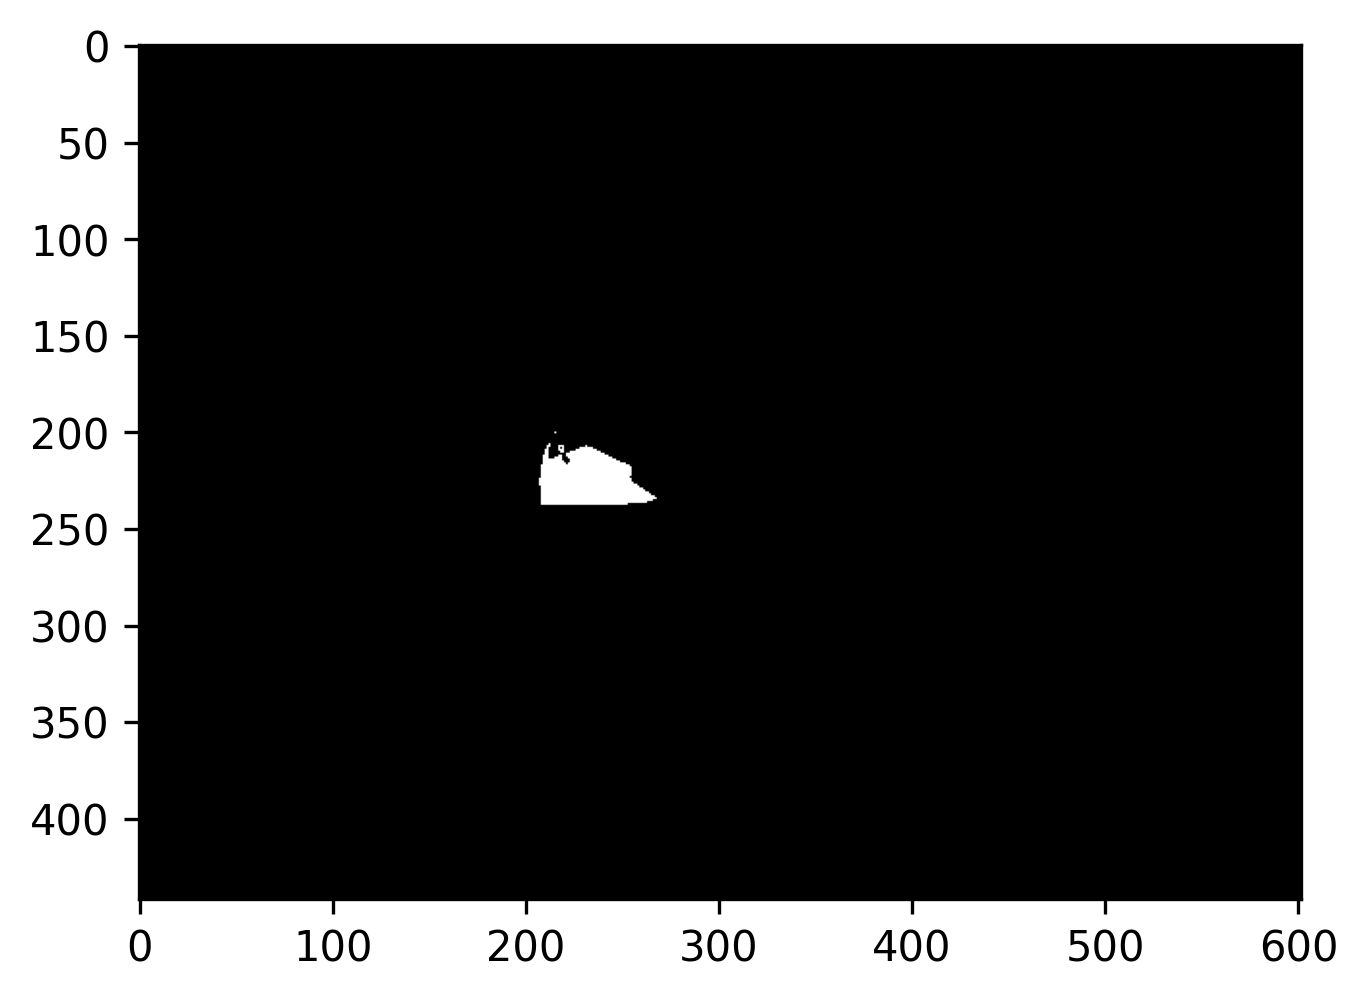

In [243]:
plt.figure(figsize=(5,5), dpi=300)
plt.imshow(curr_observed_map, cmap="gray")
plt.show()

In [47]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


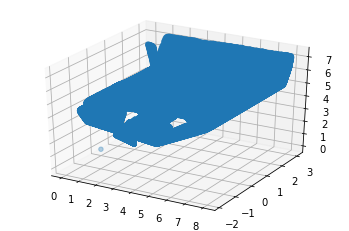

In [50]:
 fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dxyz[:, :, 0].reshape(-1, 1)
y = dxyz[:, :, 1].reshape(-1, 1)
z = dxyz[:, :, 2].reshape(-1, 1)
ax.scatter(x, y, z)
plt.show()